### Usando nn.Embedings en lugar de glove o word2vec preentrenados

In [1]:
from RNNs_sentimiento03 import BidirectionalRNN_ANN


In [ ]:
import torch
import torch.nn as nn
import re
import pandas as pd
import matplotlib.pyplot as plt

class Preprocessor:    
    def __init__(self, path: str, embedding_dim=100) -> None:
        # Inicialización básica
        self.path = path
        self.text = self.read_path(self.path)  # Leer el archivo de texto
        self.data = self.create_data(self.text)  # Crear diccionario de párrafos y sentimientos
        self.df = self.create_df(self.data)  # Crear DataFrame con los datos
        self.df_words = self.create_df_words(self.df)  # DataFrame con cada palabra del texto
        
        # Construir vocabulario y asignar índices
        self.build_vocabulary(self.df_words)
        self.embedding_dim = embedding_dim
        self.embedding_layer = nn.Embedding(len(self.vocab), embedding_dim)

        # Crear listas de tensores de secuencias y targets
        self.X, self.y = self.create_X_y_words(self.df_words)  # Para entrenamiento con secuencia de embeddings
        self.X_se, self.y_se = self.create_X_y_sentence_embedding(self.data)  # Para entrenamiento con embedding promedio de cada párrafo
    
    def read_path(self, path: str) -> str:
        ''' Método que lee un archivo de texto y retorna el texto '''
        with open(path, 'r', encoding='utf-8') as file:
            text = file.read()
        return text
    
    def build_vocabulary(self, df):
        ''' Construir vocabulario a partir de las palabras en el DataFrame '''
        words = set()
        for parrafo in df['parrafos']:
            words.update(parrafo)
        self.vocab = {word: idx for idx, word in enumerate(words)}  # Asignar índice único a cada palabra
    
    def get_embedding_words(self, texto: str) -> torch.Tensor:
        ''' Método que obtiene los embeddings de un texto usando nn.Embedding '''
        texto = re.findall(r'\w+', texto.lower())
        indices = [self.vocab[word] for word in texto if word in self.vocab]
        if indices:
            embeddings = self.embedding_layer(torch.tensor(indices))
        else:
            embeddings = torch.zeros(self.embedding_dim)  # Vector de ceros si no se encuentran palabras válidas
        return embeddings

    def get_embedding_sentence(self, parrafo: str) -> torch.Tensor:
        ''' Método que obtiene el embedding promedio de un párrafo '''
        parrafo = re.findall(r'\w+', parrafo.lower())
        indices = [self.vocab[word] for word in parrafo if word in self.vocab]
        if indices:
            embeddings = self.embedding_layer(torch.tensor(indices)).mean(dim=0)
            embeddings = embeddings.view(1, -1)  # Reshape
        else:
            embeddings = torch.zeros(self.embedding_dim)
        return embeddings

    def create_data(self, text: str) -> dict:
        ''' Método que crea un diccionario de párrafos y sentimientos '''
        parrafos = re.findall(r'Parrafo_\d+:\n(.*?)\nsentimiento_\d+:\n', text, re.DOTALL)
        sentimientos = re.findall(r'sentimiento_\d+:\n(.*?)(?:\n|$)', text, re.DOTALL)
        sentimientos = [float(sentimiento) for sentimiento in sentimientos]
        data = {'parrafos': parrafos, 'sentimientos': sentimientos}
        return data
    
    def create_df(self, data: dict) -> pd.DataFrame:
        ''' Método que crea un DataFrame a partir del diccionario de párrafos y sentimientos '''
        df = pd.DataFrame(data)
        return df
    
    def create_df_words(self, df: pd.DataFrame) -> pd.DataFrame:
        ''' Método que crea un DataFrame de palabras individuales y sentimientos '''
        df_words = df.copy()
        df_words['parrafos'] = df['parrafos'].apply(lambda x: re.findall(r'\w+', x.lower()))
        return df_words
    
    def create_X_y_words(self, df: pd.DataFrame) -> list:
        ''' Método que crea listas de embeddings de secuencias y etiquetas de sentimientos '''
        X = []
        y = []
        for parrafo, sentimiento in zip(df['parrafos'], df['sentimientos']):
            indices = [self.vocab[word] for word in parrafo if word in self.vocab]
            if indices:
                paragraph_embedding = [self.embedding_layer(torch.tensor([idx])) for idx in indices]
            else:
                paragraph_embedding = [torch.zeros(self.embedding_dim)]
            X.append(torch.cat(paragraph_embedding))
            y.append(torch.tensor(sentimiento, dtype=torch.float32))
        return X, y

    def create_X_y_sentence_embedding(self, df: dict) -> list:
        X = []
        y = []
        for parrafo, sentimiento in zip(df['parrafos'], df['sentimientos']):
            paragraph_embedding = self.get_embedding_sentence(parrafo)
            X.append(paragraph_embedding)
            y.append(torch.tensor(sentimiento, dtype=torch.float32))
        return X, y


class SentimentBidirectional_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, Preprocessor, dropout=0.5, lr=0.001):
        super(SentimentBidirectional_RNN, self).__init__()
        self.Preprocessor = Preprocessor
        self.embedding_layer = Preprocessor.embedding_layer  # Capa de embeddings
        self.model = BidirectionalRNN_ANN(input_size, hidden_size, output_size)
        self.loss = nn.MSELoss()
        self.dropout = nn.Dropout(dropout)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def train(self, X_train, y_train, epoch=10, batch_size=32):
        self.embedding_layer.requires_grad = True  # Permitir que los embeddings se entrenen
        loss_list = []
        
        y_train = torch.stack(y_train)  # Combina y_train en un solo tensor para cada batch

        for e in range(epoch):
            total_loss = 0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                
                self.optimizer.zero_grad()
                outputs = []
                
                for secuencia in X_batch:
                    output = self.model(secuencia)
                    outputs.append(output)

                # Convertir outputs a un tensor de la misma dimensión que y_batch
                outputs = torch.cat(outputs).squeeze()
                
                # Calcular la pérdida
                loss = self.loss(outputs, y_batch)
                
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                
            loss_list.append(total_loss)
            print(f'Epoch {e+1} - Loss: {total_loss}')
        self.loss_list = loss_list

    def predict(self, texto):
        """
        Método para predecir el sentimiento de un texto dado.
        Convierte el texto en embeddings y calcula el sentimiento usando el modelo entrenado.
        """
        # Obtener el embedding promedio del párrafo usando el preprocesador
        secuencia = self.Preprocessor.get_embedding_sentence(texto)
        
        # Verificar si el embedding del párrafo es válido
        if secuencia is None or len(secuencia) == 0:
            print("No se encontraron palabras válidas en el vocabulario para esta oración.")
            return None
        
        # Obtener la predicción pasando el embedding promedio al modelo
        with torch.no_grad():  # Desactivamos el cálculo de gradientes para la predicción
            output = self.model(secuencia)
            output = output.squeeze().item()  # Convertir el tensor a un valor escalar
        
        return output

# Ploteo de la pérdida
def plot_loss(loss_list):
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.show()


In [42]:
# Inicializar el preprocesador para cargar los datos y crear el vocabulario
preprocessor = Preprocessor(path="./train_data.txt", embedding_dim=100)

In [44]:
preprocessor.X_se

[]

In [37]:
preprocessor.y[0]

tensor(0.9000)

In [38]:
X_train, y_train = preprocessor.X_se, preprocessor.y_se  



In [ ]:
# Parámetros del modelo
input_size = preprocessor.embedding_dim
hidden_size =  300 # tamaño de la capa oculta, ajustable según necesidad
output_size = 1   # salida para una tarea de regresión de sentimiento
dropout = 0.5
learning_rate = 0.001
epoch = 100        # número de épocas para entrenamiento

# Crear el modelo
model = SentimentBidirectional_RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    Preprocessor=preprocessor,
    dropout=dropout,
    lr=learning_rate
)


In [ ]:
# Entrenar el modelo
model.train(X_train, y_train, epoch=epoch, batch_size=32)

RuntimeError: both arguments to linear need to be at least 1D, but they are 0D and 2D

In [10]:
# Ploteamos el loss
def plot_loss(loss_list):
    import matplotlib.pyplot as plt
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.show()

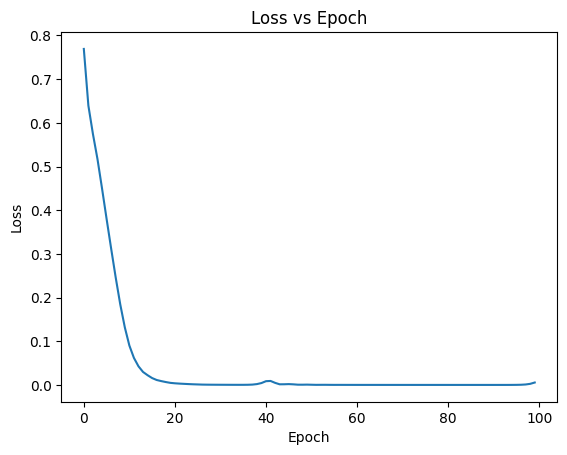

In [11]:
# Ploteamos el loss
plot_loss(model.loss_list)